### Polynomial Chaos Expansions

The main idea behind [PCE](https://econpapers.repec.org/article/eeereensy/v_3a93_3ay_3a2008_3ai_3a7_3ap_3a964-979.htm) is to search an interpolator that lives in the subspace of low-degree polynomials (or rather, in the tensor product of such subspaces).

In this notebook we will tackle a regression problem: we have $N$ features that are used to train an $N$-dimensional TT model. Each feature $x_n$ is mapped to the $n$-th entry of the tensor; in other words, we learn a function as a discretized tensor:

$$f(x) = f(x_0, \dots, x_{N-1}) \approx \mathcal{T}[i_0, \dots, i_{N-1}]$$

Here we will use a noisy 5D synthetic function: $f(x) := \sum w_n x_n^2 + \epsilon$ where the $w_n$ are random weights and $\epsilon$ is Gaussian noise added to every observation.

In [11]:
import torch
import tntorch as tn

P = 200
ntrain = int(P*0.75)
N = 5
ticks = 32  # We will use a 32^5 tensor

X = torch.randint(0, ticks, (P, N))  # Make features be between 0 and ticks-1 (will be used directly as tensor indices)
ws = torch.rand(N)
y = torch.matmul(X**2, ws)
y += torch.randn(y.shape)*torch.std(y)/10  # Gaussian noise proportional to the clean signal's sigma

# Split into train/test
X_train = X[:ntrain]
y_train = y[:ntrain]
X_test = X[ntrain:]
y_test = y[ntrain:]

Our first attempt will be to learn this problem using only the low rank assumption, i.e. plain [tensor completion](https://github.com/rballester/tntorch/blob/master/tutorials/completion.ipynb):

In [12]:
t = tn.rand(shape=[ticks]*N, ranks_tt=2, requires_grad=True)

def loss(t):
    return tn.relative_error(y_train, t[X_train])**2
tn.optimize(t, loss)

iter: 0      | loss:   0.999045 | total time:    0.0032
iter: 500    | loss:   0.836139 | total time:    1.0223
iter: 1000   | loss:   0.083866 | total time:    1.9843
iter: 1500   | loss:   0.014768 | total time:    3.0171
iter: 2000   | loss:   0.008732 | total time:    4.3223
iter: 2500   | loss:   0.005784 | total time:    5.4598
iter: 3000   | loss:   0.003838 | total time:    6.5598
iter: 3500   | loss:   0.002404 | total time:    7.7174
iter: 4000   | loss:   0.001408 | total time:    8.6591
iter: 4500   | loss:   0.000787 | total time:    9.6947
iter: 5000   | loss:   0.000424 | total time:   10.7685
iter: 5500   | loss:   0.000227 | total time:   11.7960
iter: 6000   | loss:   0.000121 | total time:   12.7728
iter: 6141   | loss:   0.000100 | total time:   13.0770 <- converged (tol=0.0001)


This TT did very well for the training data, but clearly overfitted:

In [13]:
print('Test relative error:', tn.relative_error(y_test, t[X_test]))
print('The model overfitted: it has {} degrees of freedom, and there are {} training instances'.format(tn.dof(t), len(X_train)))

Test relative error: tensor(0.3962, grad_fn=<DivBackward1>)
The model overfitted: it has 512 degrees of freedom, and there are 150 training instances


We can look at the groundtruth vs. prediction for the training and test splits:

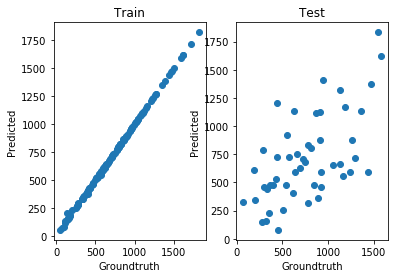

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def show():
    fig = plt.figure()
    fig.add_subplot(121)
    plt.scatter(y_train, t[X_train].full().detach().numpy())
    plt.xlabel('Groundtruth')
    plt.ylabel('Predicted')
    plt.title('Train')
    fig.add_subplot(122)
    plt.scatter(y_test, t[X_test].full().detach().numpy())
    plt.xlabel('Groundtruth')
    plt.ylabel('Predicted')
    plt.title('Test')
    plt.show()
    
show()

### Seeking a Low-degree Polynomial Solution

Next we will try a PCE-like solution. The good news is that PCE is essentially a [Tucker decomposition](https://epubs.siam.org/doi/pdf/10.1137/07070111X) with certain custom factors, namely polynomial, and we can emulate this in *tntorch* via the TT-Tucker model. Essentially we will fix polynomial bases and impose low TT-rank structure on the learnable coefficients.

In [22]:
t = tn.rand(shape=[ticks]*N, ranks_tt=2, ranks_tucker=3, requires_grad=True)  # There are both TT-ranks *and* Tucker-ranks
t

5D TT-Tucker tensor:

 32  32  32  32  32
  |   |   |   |   |
  2   2   2   2   2
 (0) (1) (2) (3) (4)
 / \ / \ / \ / \ / \
1   2   2   2   2   1



Note the shape of that tensor network: cores are no longer $2 \times 32 \times 2$, but $2 \times 3 \times 2$. Their middle dimension is now *compressed* using a so-called *factor matrix* of size $32 \times 3$. In other words, we are expressing each slice of a TT model as a linear combination of three "master" slices only.

Furthermore, we want those factors to be fixed bases and contain nicely chosen 1D polynomials along their columns:

In [23]:
t.set_factors('legendre', requires_grad=False)  # We set the factors to Legendre polynomials, and fix them (won't be changed during optimization) 

As expected, the factors' columns are Legendre polynomials of increasing order:

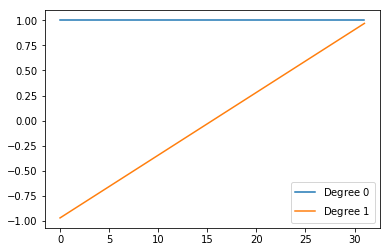

In [24]:
for i in range(t.ranks_tucker[0]):
    plt.plot(t.Us[0][:, i].numpy(), label='Degree ${}$'.format(i))
plt.legend()
plt.show()

We are now ready to proceed with our usual optimization target, this time just with this "smarter" tensor:

In [25]:
tn.optimize(t, loss)

iter: 0      | loss:   0.999286 | total time:    0.0026
iter: 500    | loss:   0.782773 | total time:    1.4275
iter: 1000   | loss:   0.034538 | total time:    2.7575
iter: 1261   | loss:   0.024786 | total time:    3.4050 <- converged (tol=0.0001)


In [26]:
print('Test relative error:', tn.relative_error(y_test, t[X_test]))
print('This model is more restrictive: it only has {} degrees of freedom'.format(tn.dof(t)))

Test relative error: tensor(0.1478, grad_fn=<DivBackward1>)
This model is more restrictive: it only has 32 degrees of freedom


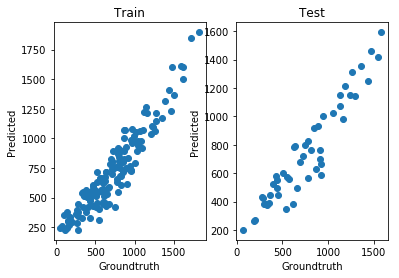

In [27]:
show()